In [1]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split

from tensorflow import keras 
from keras.layers import TextVectorization, Input, Embedding, concatenate, Conv1D, GlobalMaxPooling1D, RepeatVector, LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping
from keras.models import Model

from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import tensorflow as tf
tf.keras.utils.set_random_seed(123)

Mounted at /content/drive


In [2]:
trainDF = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/UCI_Sentiment_Analysis/gloveEmbedding_train.parquet")

testDF = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/UCI_Sentiment_Analysis/gloveEmbedding_test.parquet")

In [3]:
# Positve
trainDF[ trainDF["sentiment"] == 1 ].head(5)

,id,rating,sentiment,wordEmbedding
0,1175,9,1,"[0.013433628, 0.008061813, 0.19747755, -0.3195..."
1,4383,9,1,"[-0.017688854, 0.17036815, 0.28469002, -0.2339..."
2,10044,9,1,"[-0.03156714, 0.18471205, 0.22300884, -0.15945..."
3,4076,10,1,"[-0.07171856, 0.20415959, 0.289257, -0.1868104..."
4,2662,10,1,"[-0.025108574, 0.15275864, 0.22979191, -0.1917..."


In [4]:
# Negative
trainDF[ trainDF["sentiment"] == 0 ].head(5)

,id,rating,sentiment,wordEmbedding
5,1930,4,0,"[-0.08480997, 0.23871018, 0.26606047, -0.17039..."
6,1929,4,0,"[-0.0904777, 0.2393774, 0.27164343, -0.1729672..."
9,7726,1,0,"[-0.03266518, 0.15753976, 0.29961297, -0.26573..."
10,2981,1,0,"[-0.04853995, 0.23368208, 0.29547942, -0.26390..."
11,1048,4,0,"[0.029550904, 0.20431304, 0.25805327, -0.21469..."


In [5]:
X_train = np.stack(trainDF['wordEmbedding'].to_numpy())
Y_train = trainDF["sentiment"].to_numpy()

X_test = np.stack(testDF['wordEmbedding'].to_numpy())
Y_test = testDF["sentiment"].to_numpy()

x_train, x_validation, y_train, y_validation = train_test_split(X_train, Y_train, test_size=0.1, random_state = 123)

In [6]:
# GloVe
print("GloVe: {}".format(X_train.shape) )
print(X_train)

GloVe: (25000, 100)
[[ 0.01343363  0.00806181  0.19747755 ...  0.02840807  0.32913905
   0.0634177 ]
 [-0.01768885  0.17036815  0.28469002 ... -0.2994456   0.18551742
   0.15101801]
 [-0.03156714  0.18471205  0.22300884 ... -0.18936291  0.28109896
   0.06738407]
 ...
 [-0.01836912 -0.0339475   0.21474963 ... -0.38558358  0.23575287
   0.13823874]
 [ 0.00851601  0.34631148  0.1887047  ...  0.25152472  0.48830858
  -0.07344001]
 [ 0.06613751  0.22457284  0.44665167 ... -0.32943818  0.3227977
   0.29882333]]


In [7]:
input_layer = Input( shape = (x_train.shape[1], ) )

repeat_layer_1 = RepeatVector(256)(input_layer)

conv_layer_1 = Conv1D(20, kernel_size=2, padding='same', activation='relu')(repeat_layer_1)
pool_1 = GlobalMaxPooling1D()(conv_layer_1)

conv_layer_2 = Conv1D(20, kernel_size=3, padding='same', activation='relu')(repeat_layer_1)
pool_2 = GlobalMaxPooling1D()(conv_layer_2)

conv_layer_3 = Conv1D(20, kernel_size=4, padding='same', activation='relu')(repeat_layer_1)
pool_3 = GlobalMaxPooling1D()(conv_layer_3)

conv_layer_4 = Conv1D(20, kernel_size=5, padding='same', activation='relu')(repeat_layer_1)
pool_4 = GlobalMaxPooling1D()(conv_layer_4)

concat_layer = concatenate( [pool_1, pool_2, pool_3, pool_4] , axis=-1)

dropout = Dropout(0.33)(concat_layer)

output_layer = Dense(2, activation='softmax')(dropout)

model = Model(inputs = input_layer, outputs = output_layer)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 repeat_vector (RepeatVector)   (None, 256, 100)     0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 256, 20)      4020        ['repeat_vector[0][0]']          
                                                                                                  
 conv1d_1 (Conv1D)              (None, 256, 20)      6020        ['repeat_vector[0][0]']          
                                                                                              

In [8]:
history = model.fit(
    x_train, 
    y_train,
    epochs = 100,
    validation_data = ( x_validation , y_validation ),
    callbacks = [ EarlyStopping(patience = 2, monitor = 'val_loss') ],
    shuffle = False,
    verbose = 2
    )

Epoch 1/100
704/704 - 12s - loss: 0.5106 - acc: 0.7477 - val_loss: 0.4666 - val_acc: 0.7864 - 12s/epoch - 18ms/step
Epoch 2/100
704/704 - 3s - loss: 0.4626 - acc: 0.7855 - val_loss: 0.4582 - val_acc: 0.7876 - 3s/epoch - 4ms/step
Epoch 3/100
704/704 - 3s - loss: 0.4544 - acc: 0.7910 - val_loss: 0.4588 - val_acc: 0.7868 - 3s/epoch - 4ms/step
Epoch 4/100
704/704 - 3s - loss: 0.4492 - acc: 0.7958 - val_loss: 0.4466 - val_acc: 0.7948 - 3s/epoch - 4ms/step
Epoch 5/100
704/704 - 3s - loss: 0.4461 - acc: 0.7953 - val_loss: 0.4445 - val_acc: 0.7948 - 3s/epoch - 4ms/step
Epoch 6/100
704/704 - 3s - loss: 0.4435 - acc: 0.7973 - val_loss: 0.4413 - val_acc: 0.7980 - 3s/epoch - 4ms/step
Epoch 7/100
704/704 - 4s - loss: 0.4412 - acc: 0.7980 - val_loss: 0.4386 - val_acc: 0.7972 - 4s/epoch - 6ms/step
Epoch 8/100
704/704 - 3s - loss: 0.4385 - acc: 0.7992 - val_loss: 0.4363 - val_acc: 0.7980 - 3s/epoch - 4ms/step
Epoch 9/100
704/704 - 3s - loss: 0.4376 - acc: 0.8007 - val_loss: 0.4353 - val_acc: 0.7968 - 

In [9]:
model_path = '/content/drive/MyDrive/Colab Notebooks/UCI_Sentiment_Analysis/Models/glove_cnn.h5'
# model = keras.models.load_model(model_path)

782/782 [==============================] - 2s 2ms/step


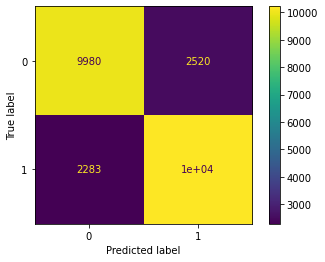

In [10]:
y_predict = [ score.argmax() for score in history.model.predict(X_test) ]

matrix = confusion_matrix( Y_test, y_predict )

ConfusionMatrixDisplay(matrix).plot()

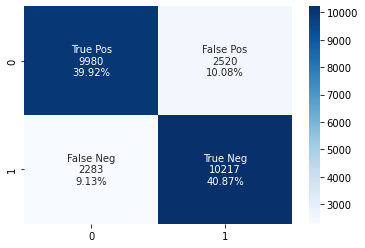

In [11]:
group_names = ['True Pos','False Pos','False Neg','True Neg']
group_counts = ["{0:0.0f}".format(value) for value in
                matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     matrix.flatten()/np.sum(matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues')

In [12]:
history.model.evaluate(X_test, Y_test)

print( classification_report(Y_test, y_predict, target_names=['Negative', 'Positive']) )

782/782 [==============================] - 2s 3ms/step - loss: 0.4249 - acc: 0.8079
              precision    recall  f1-score   support

    Negative       0.81      0.80      0.81     12500
    Positive       0.80      0.82      0.81     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000



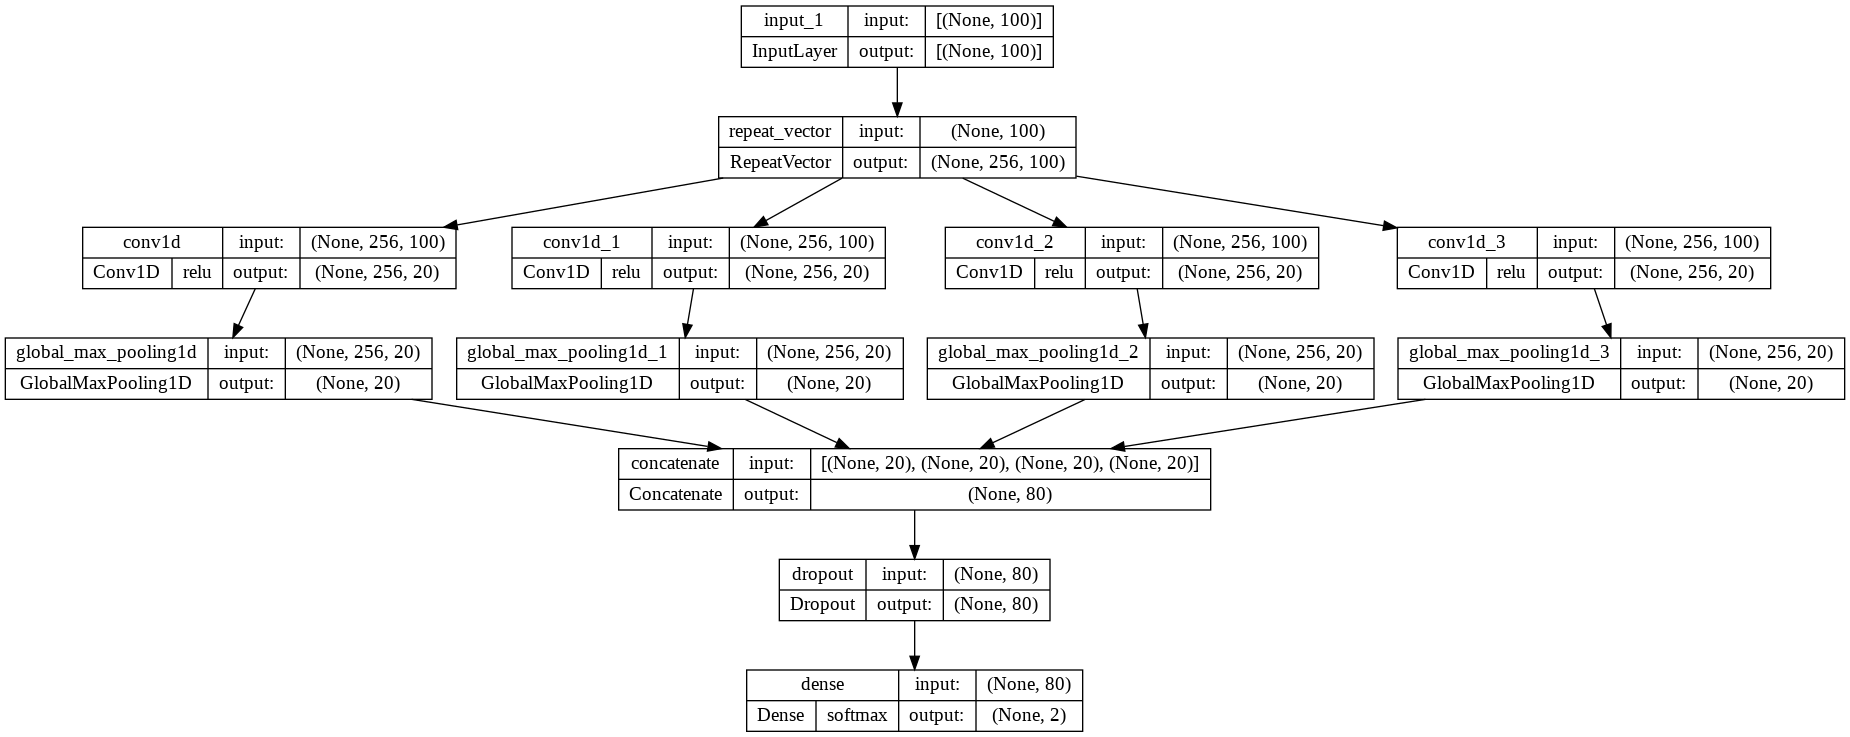

In [13]:
keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True)

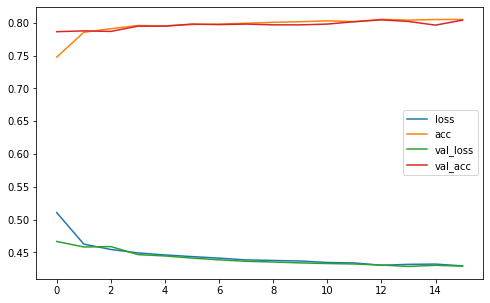

In [14]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [15]:
model.save(model_path, overwrite=False)